# A simple simulator for Stratified media under normal incidence

## Imports

In [34]:
import jax
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt
from scipy.constants import epsilon_0, c as c0

In [2]:
import sax
import meow
import meow.eme.propagate
from sax.backends import circuit_backends
from sax.saxtypes import scoo
sax_backend = meow.eme.sax._validate_sax_backend("klu")

## Layer Stack

In [18]:
ns = [2, 1.889+0.0035j, 1.802+0.0562j, 2.321+0.291j, 1.519+0.0043j]
ds = [1, 0.15, 0.03, 0.3, 0.2]
wl = 0.524
xi = jnp.cumsum(jnp.array(ds))

## Fresnel and Propagation

In [19]:
def fresnel_mirror_ij(ni=1.0, nj=1.0):
    """Model a (fresnel) interface between twoo refractive indices

    Args:
        ni: refractive index of the initial medium
        nf: refractive index of the final
    """
    r_fresnel_ij = (ni - nj) / (ni + nj)  # i->j reflection
    t_fresnel_ij = 2 * ni / (ni + nj)  # i->j transmission
    r_fresnel_ji = -r_fresnel_ij  # j -> i reflection
    t_fresnel_ji = (1 - r_fresnel_ij**2) / t_fresnel_ij  # j -> i transmission
    sdict = {
        ("left", "left"): r_fresnel_ij,
        ("left", "right"): t_fresnel_ij,
        ("right", "left"): t_fresnel_ji,
        ("right", "right"): r_fresnel_ji,
    }
    return sdict


def propagation_i(ni=1.0, di=0.5, wl=wl):
    """Model the phase shift acquired as a wave propagates through medium A

    Args:
        ni: refractive index of medium (at wavelength wl)
        di: [μm] thickness of layer
        wl: [μm] wavelength
    """
    prop_i = jnp.exp(1j * 2 * jnp.pi * ni * di / wl)
    sdict = {
        ("left", "right"): prop_i,
        ("right", "left"): prop_i,
    }
    return sdict

## Layers
let's set up the sax components for the different layers

In [20]:
identity = fresnel_mirror_ij(1, 1)

In [21]:
propagations=[propagation_i(ni, di) for ni, di in zip(ns, ds)]
propagations=[identity]+propagations+[identity]
propagations = {f"p_{i}": sax.sdense(p) for i, p in enumerate(propagations)}

In [22]:
padded_ns = [1]+ns+[1]
interfaces=[fresnel_mirror_ij(ni, nj) for ni, nj in zip(padded_ns, padded_ns[1:])]
#interfaces=[identity]+interfaces+[identity]
interfaces = {f"i_{i}_{i+1}": sax.sdense(p) for i, p in enumerate(interfaces)}

## Propagate Interface Pairs 
Combine successive propagation sections and interfaces into Propagate Interface Pairs (pi_pairs).

In [23]:
pairs = meow.eme.propagate.pi_pairs(propagations, interfaces, sax_backend)

In [24]:
pairs

[(Array([[-0.33333333+0.j,  0.66666667+0.j],
         [ 1.33333333+0.j,  0.33333333+0.j]], dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[-0.01975275-2.06224702e-02j,  0.41825105-9.39661605e-01j],
         [ 0.39668253-8.86778446e-01j, -0.02854121+9.25660640e-04j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[ 0.02717729-0.00132731j, -0.9874581 -0.24341025j],
         [-0.93521932-0.25984497j, -0.0233338 +0.01465539j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[0.00878516-0.13192698j, 0.70706964+0.47896054j],
         [0.85533807+0.70441435j, 0.12975476+0.04602211j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[-0.00841235-0.02592388j, -0.22041826+0.36506186j],
         [-0.11324729+0.25270837j, -0.2133341 -0.05825584j]],      dtype=complex128),
  {'left': 0, 'right': 1}),
 (Array([[ 0.1075173 +0.17081393j, -1.0461972 -0.57472254j],
         [-0.68980628-0.37640314j, -0.20603645-0.00135532j]],      dtype=complex128),
  {

## Accumulate
Split the whole device into left and right sections with the split moving from left to right

In [25]:
l2rs = meow.eme.propagate.l2r_matrices(pairs, identity, sax_backend)
r2ls = meow.eme.propagate.r2l_matrices(pairs, sax_backend)

## Excite from the left

In [26]:
ex_l = jnp.array([1])
ex_r = jnp.array([0])

## Calculate Amplitudes
TODO: explain how it works

In [27]:
forwards, backwards = meow.eme.propagate.propagate(l2rs, r2ls, ex_l, ex_r)

In [28]:
forwards

[Array([1.+0.j], dtype=complex128),
 Array([1.25383339-0.02367114j], dtype=complex128),
 Array([0.47782442-1.11538203j], dtype=complex128),
 Array([-0.74117674+0.9167206j], dtype=complex128),
 Array([-1.28082908+0.27057417j], dtype=complex128),
 Array([0.06083769-0.35234047j], dtype=complex128),
 Array([-0.17458828+0.22014717j], dtype=complex128)]

In [29]:
backwards

[Array([-0.49233321-0.04734227j], dtype=complex128),
 Array([-0.23849982-0.07101341j], dtype=complex128),
 Array([-0.04378398-0.20744947j], dtype=complex128),
 Array([0.09432121+0.15549362j], dtype=complex128),
 Array([0.01311736+0.0613464j], dtype=complex128),
 Array([0.06672576-0.02749077j], dtype=complex128),
 Array([0.+0.j], dtype=complex128)]

In [89]:
def fields(padded_ns, xi, forwards, backwards, x):
    """Calculates the fields within a stack at given positions x
    Attention xi > 0
    """
    xi = onp.concatenate([[-onp.inf, 0], xi, [onp.inf]])
    E_tot = onp.zeros((len(x),), dtype=complex)
    Abs_tot = onp.zeros((len(x),), dtype=complex)
    for n, forward, backward, x_min, x_max in zip(padded_ns, forwards, backwards, xi, xi[1:]):
        has_contribution = onp.any(onp.logical_and(x > x_min, x < x_max))
        if not has_contribution:
            continue
        #print(f"{n}: {x_min} - {x_max}: -> {forward[0]}; <- {backward[0]}")
        i_min = onp.argmax(x >= x_min)
        i_max = onp.argmax(x > x_max)
        
        if i_max == 0:
            x_ = x[i_min:]
        else:
            x_ = x[i_min:i_max]

        if onp.isinf(x_min):
            x_local = x_
        else:
            x_local = x_ - x_min
        E_local = forward*onp.exp(2j * onp.pi * n / wl * x_local)
        E_local += backward*onp.exp(-2j * onp.pi * n / wl * x_local)

        if i_max == 0:
            E_tot[i_min:] = E_local
        else:
            E_tot[i_min:i_max] = E_local

        eps = n**2 * epsilon_0
        omega = 2 * onp.pi * c0/wl
        Abs_local = 0.5* omega * eps.imag * onp.abs(E_local)**2
        if i_max == 0:
            Abs_tot[i_min:] = Abs_local
        else:
            Abs_tot[i_min:i_max] = Abs_local
            
    return E_tot, Abs_tot

In [94]:
x = jnp.linspace(xi[-3]-0.1, xi[-2]+0.1, 400)
field, absorption = fields(padded_ns, xi, forwards, backwards, x)

Text(0, 0.5, '$|E(x)|$')

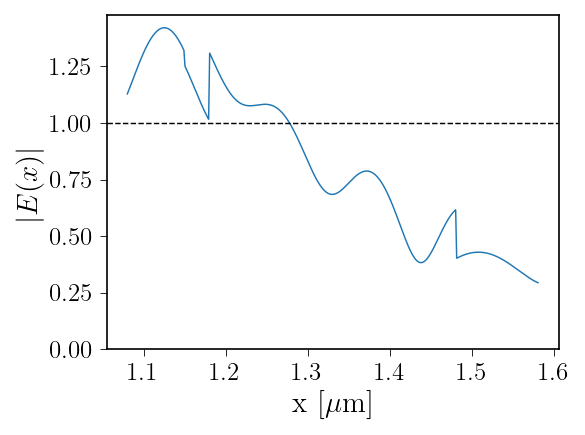

In [95]:
plt.plot(x, onp.abs(field))
plt.axhline(1, color="k", linestyle="--")
plt.ylim((0, None))
plt.xlabel("x [$\mu$m]")
plt.ylabel("$|E(x)|$")

/scratch/local/jdf/conda/envs/meow/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/scratch/local/jdf/conda/envs/meow/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Absorption')

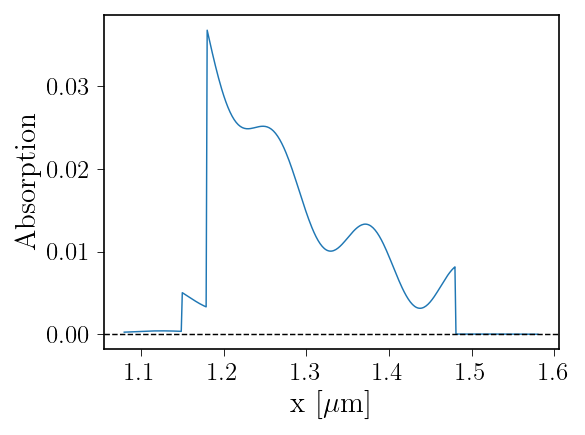

In [96]:
plt.plot(x, absorption)
plt.axhline(0, color="k", linestyle="--")
plt.xlabel("x [$\mu$m]")
plt.ylabel("Absorption")

